Imports

In [1]:
import sys
import os
import glob
import random
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

Read Files

In [2]:
files = []
path = 'archive-2/lgg-mri-segmentation/kaggle_3m/'

# the ground truth are files marked with 'mask'
mask_files = glob.glob(path + '*/*_mask*')
data = pd.read_csv(path + "data.csv")
for i in mask_files:
    # for the truthful mask files, retrieve the blank image
    files.append(i.replace('_mask',''))

Preprocess Data

In [3]:
df = pd.DataFrame()
df['img']= files
df['mask']= mask_files

# label the classification from the masked files
def labels(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0:
        return 1
    else: return 0

df['label'] = df['mask'].apply(labels)
print("Number of non tumours: " + str(df.label.value_counts()[0]))
print("Number of tumours: " + str(df.label.value_counts()[1]))


Number of non tumours: 2556
Number of tumours: 1373


Since the number of classifications are somewhat evenly distributed, we can directly use the whole dataset.

Group Dataset By Patients

In [12]:
# group by patients

# def path(x):
#   y = x.split("/")[-1]
#   z = y.split(".")[0]
#   z1 = z.split("_")
#   return "_".join(z1[:-2])

# df['Patient'] = df.img.apply(path)
# k = df.groupby(df.Patient)
# l = k.size()
# rows, cols = 5, 5
# l = k.get_group('TCGA_CS_4941')


Load an image and it's corresponding mask for one patient

In [6]:
# fig = plt.figure(figsize=(16, 16))

# plt.subplot(121)
# img = cv2.imread(l['img'].iloc[0], cv2.IMREAD_UNCHANGED)
# plt.imshow(img)
# plt.title("Image")

# plt.subplot(122)
# msk_path = l['mask'].iloc[0]
# msk = cv2.imread(msk_path)
# plt.imshow(msk)
# plt.title("Mask")

# plt.show()



In [13]:
df

,img,mask,label,Patient
0,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,0,kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941
1,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,1,kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941
2,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,1,kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941
3,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,1,kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941
4,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,1,kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941
...,...,...,...,...
3924,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,0,kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61B
3925,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,0,kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61B
3926,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,0,kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61B
3927,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,0,kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61B


In [99]:
# downsize the input images

import os.path
import cv2
import numpy as np
import random

def downsample_and_split(train_size):
    images = []
    masks = []

    # image size
    size = 32, 32

    # Iterate through each image in each subfolder
    for index in range(len(df.index)):
        img = df['img'][index]
        temp_img = cv2.imread(img, cv2.IMREAD_UNCHANGED)

        mask = df['mask'][index]
        temp_mask = cv2.imread(mask)

        if temp_img is None:
            continue

        # Resize the images
        temp_img = cv2.resize(temp_img, size)
        images.append(temp_img)

        temp_mask = cv2.resize(temp_mask, size)
        masks.append(temp_mask)

    
    # Convert to a numpy array
    images = np.array(images)

    
    # Normalize the images
    images = images.astype('float32')/255.0

    #np.random.shuffle(images)

    images_train = images[:int((images.shape[0]+1)*train_size)]
    images_test = images[int((images.shape[0]+1)*train_size):]

    masks = np.array(masks)

    # Normalize the masks
    masks = masks.astype('float32')/255.0

    #np.random.shuffle(masks)
    masks_train = masks[:int((masks.shape[0]+1)*train_size)]
    masks_test = masks[int((masks.shape[0]+1)*train_size):]

    return images_train, masks_train, images_test, masks_test


In [39]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the input and output shapes
input_shape = (32, 32, 3)
output_shape = (32, 32, 3)

# Define the U-Net architecture
inputs = Input(input_shape)
conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
merge6 = concatenate([drop4, up6], axis=3)
conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

up7 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
merge7 = concatenate([conv3, up7], axis=3)
conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

up8 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
merge8 = concatenate([conv2, up8], axis=3)
conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)
conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

up9 = Conv2D(32, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
merge9 = concatenate([conv1, up9], axis=3)
conv9 = Conv2D(32, 3, activation='relu', padding='same')(merge9)
conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)
conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)
conv10 = Conv2D(3, 1, activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_72 (Conv2D)             (None, 32, 32, 32)   896         ['input_4[0][0]']                
                                                                                                  
 conv2d_73 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_72[0][0]']              
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 16, 16, 32)  0           ['conv2d_73[0][0]']              
 )                                                                                          

In [100]:
X_train, Y_train, x_test, y_test = downsample_and_split(0.8)  # function to load and preprocess dataset and mask

In [101]:
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true), axis=-1) + K.sum(K.square(y_pred), axis=-1) + smooth)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

model.compile(optimizer='adam', loss=dice_coefficient_loss, metrics=[dice_coefficient])
model.fit(X_train, Y_train, batch_size=10, epochs=5, validation_split=0.1)

Epoch 1/5
283/283 [==============================] - 57s 197ms/step - loss: 0.0076 - dice_coefficient: 0.9924 - val_loss: 0.0077 - val_dice_coefficient: 0.9923
Epoch 2/5
283/283 [==============================] - 56s 199ms/step - loss: 0.0076 - dice_coefficient: 0.9924 - val_loss: 0.0077 - val_dice_coefficient: 0.9923
Epoch 3/5
283/283 [==============================] - 65s 229ms/step - loss: 0.0076 - dice_coefficient: 0.9924 - val_loss: 0.0077 - val_dice_coefficient: 0.9923
Epoch 4/5
283/283 [==============================] - 55s 193ms/step - loss: 0.0076 - dice_coefficient: 0.9924 - val_loss: 0.0077 - val_dice_coefficient: 0.9923
Epoch 5/5
283/283 [==============================] - 54s 192ms/step - loss: 0.0076 - dice_coefficient: 0.9924 - val_loss: 0.0077 - val_dice_coefficient: 0.9923


In [102]:
Y_pred = model.predict(x_test)


25/25 [==============================] - 2s 80ms/step


In [103]:
# fig = plt.figure(figsize=(16, 16))

# plt.subplot(121)
# img = cv2.imread(l['img'].iloc[0], cv2.IMREAD_UNCHANGED)
# plt.imshow(img)
# plt.title("Image")

# plt.subplot(122)
# msk_path = l['mask'].iloc[0]
# msk = cv2.imread(msk_path)
# plt.imshow(msk)
# plt.title("Mask")

# plt.show()

#print(img.shape)

Text(0.5, 1.0, 'Pred Image 105')

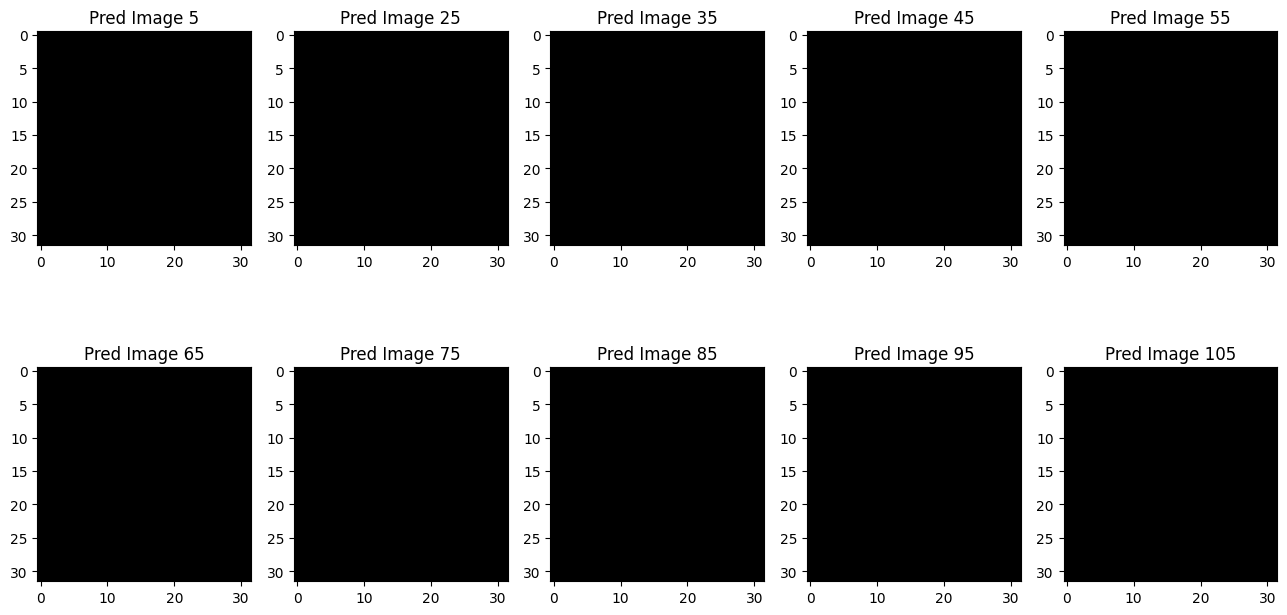

In [104]:
plt.figure(figsize=(16,8))
plt.subplot(251)
plt.imshow(Y_pred[5])
plt.title('Pred Image 5')
plt.subplot(252)
plt.imshow(Y_pred[25])
plt.title('Pred Image 25')
plt.subplot(253)
plt.imshow(Y_pred[35])
plt.title('Pred Image 35')
plt.subplot(254)
plt.imshow(Y_pred[45])
plt.title('Pred Image 45')
plt.subplot(255)
plt.imshow(Y_pred[55])
plt.title('Pred Image 55')
plt.subplot(256)
plt.imshow(Y_pred[65])
plt.title('Pred Image 65')
plt.subplot(257)
plt.imshow(Y_pred[75])
plt.title('Pred Image 75')
plt.subplot(258)
plt.imshow(Y_pred[85])
plt.title('Pred Image 85')
plt.subplot(259)
plt.imshow(Y_pred[95])
plt.title('Pred Image 95')
plt.subplot(2,5,10)
plt.imshow(Y_pred[105])
plt.title('Pred Image 105')

Text(0.5, 1.0, 'Test Image 105')

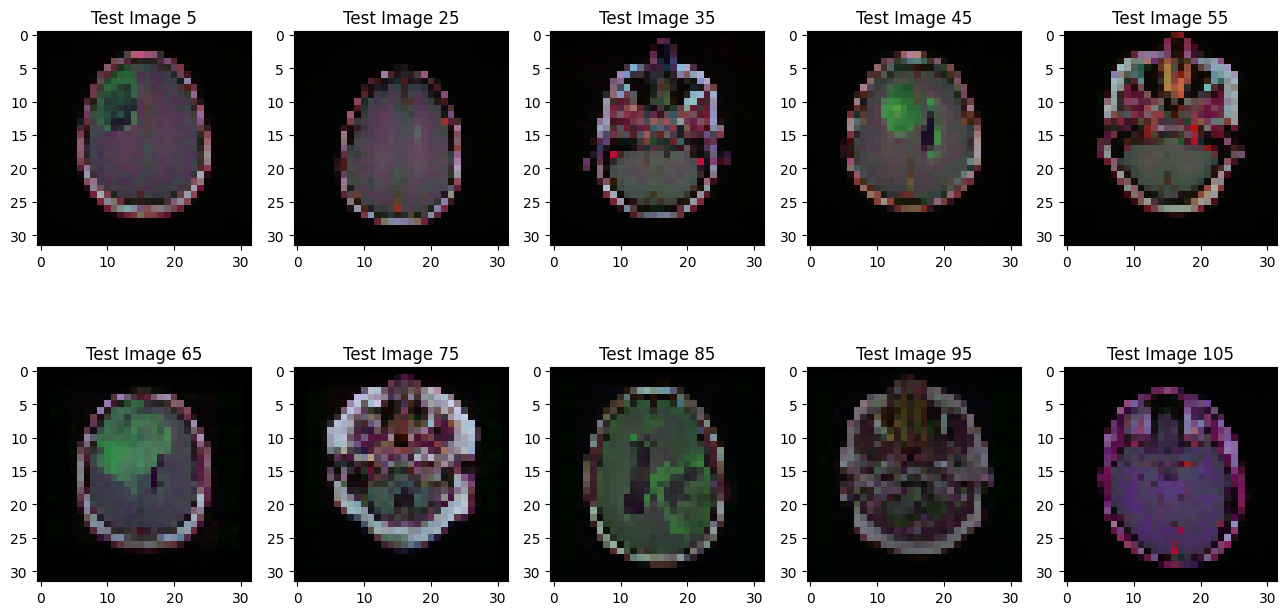

In [105]:
plt.figure(figsize=(16,8))
plt.subplot(251)
plt.imshow(x_test[5])
plt.title('Test Image 5')
plt.subplot(252)
plt.imshow(x_test[25])
plt.title('Test Image 25')
plt.subplot(253)
plt.imshow(x_test[35])
plt.title('Test Image 35')
plt.subplot(254)
plt.imshow(x_test[45])
plt.title('Test Image 45')
plt.subplot(255)
plt.imshow(x_test[55])
plt.title('Test Image 55')
plt.subplot(256)
plt.imshow(x_test[65])
plt.title('Test Image 65')
plt.subplot(257)
plt.imshow(x_test[75])
plt.title('Test Image 75')
plt.subplot(258)
plt.imshow(x_test[85])
plt.title('Test Image 85')
plt.subplot(259)
plt.imshow(x_test[95])
plt.title('Test Image 95')
plt.subplot(2,5,10)
plt.imshow(x_test[105])
plt.title('Test Image 105')

Text(0.5, 1.0, 'Test Mask 105')

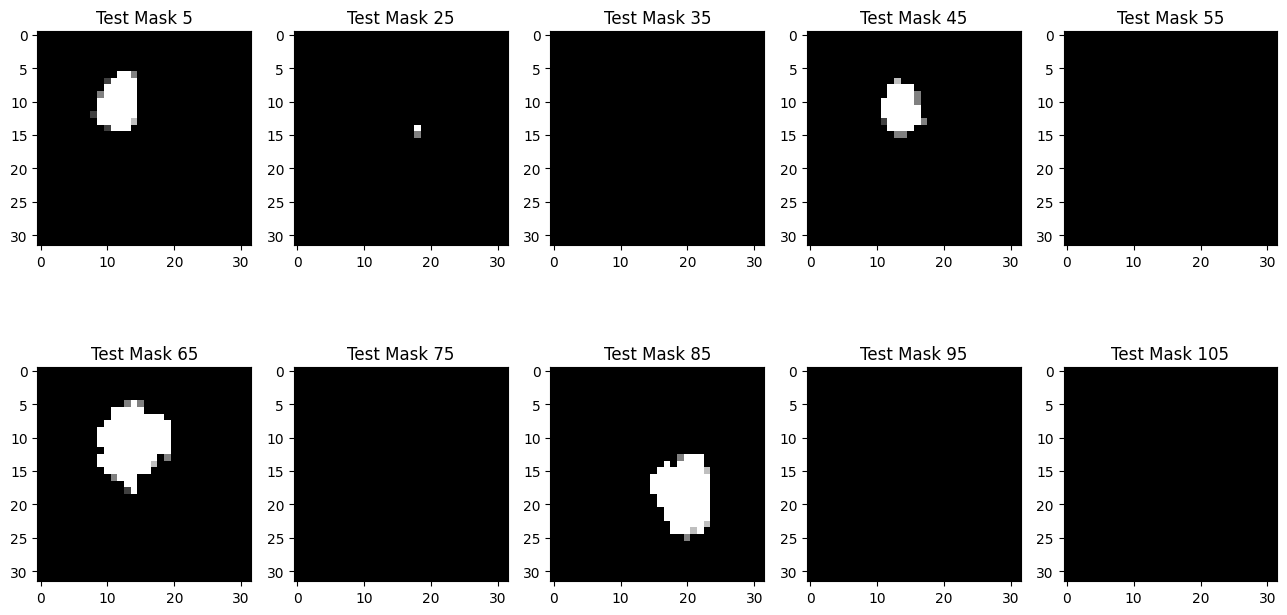

In [106]:
plt.figure(figsize=(16,8))
plt.subplot(251)
plt.imshow(y_test[5])
plt.title('Test Mask 5')
plt.subplot(252)
plt.imshow(y_test[25])
plt.title('Test Mask 25')
plt.subplot(253)
plt.imshow(y_test[35])
plt.title('Test Mask 35')
plt.subplot(254)
plt.imshow(y_test[45])
plt.title('Test Mask 45')
plt.subplot(255)
plt.imshow(y_test[55])
plt.title('Test Mask 55')
plt.subplot(256)
plt.imshow(y_test[65])
plt.title('Test Mask 65')
plt.subplot(257)
plt.imshow(y_test[75])
plt.title('Test Mask 75')
plt.subplot(258)
plt.imshow(y_test[85])
plt.title('Test Mask 85')
plt.subplot(259)
plt.imshow(y_test[95])
plt.title('Test Mask 95')
plt.subplot(2,5,10)
plt.imshow(y_test[105])
plt.title('Test Mask 105')